# Act 7. Regresion Logistica
_____________________________

- Angel Ruben Vazquez Rivera |
- Jose Israel Perez Ontiveros | A01423294  
- Maximiliano Romero Budib |

### 1. Importar librerias

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
from funpymodeling.exploratory import freq_tbl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

#Ansy colors format
reset =  "\033[0m"
black = "\033[30m"
red = '\033[31m'
green = "\033[32m"
yellow = "\033[33m"
blue = "\033[34m"
magenta = "\033[35m"
cyan = "\033[36m"
white = "\033[37m"

### 2. Cargar archivo

In [24]:
data = pd.read_csv('./Recursos/TrainingDataComplete.csv', index_col=0)
display(data)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


### 3. Preprocesamiento

- 3.1 Obtener informacion de nuestro Dataframe

In [25]:
# Verificamos info del DF
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


- 3.2 Separacion de columnas cuantitativas y cualitativas

In [26]:
# Separamos columnas cualitativas de cuantitativas
data['Risk_Flag'] = data['Risk_Flag'].replace({0: 'No', 1: 'Yes'})

dataCuantitativas = data.select_dtypes(include=['int64'])
dataCualitativas = data.select_dtypes(include=['object'])


print(f'Columnas cuantitativas:\n{dataCuantitativas.columns}')
print(f'\nColumnas cualitativas:\n{dataCualitativas.columns}')



Columnas cuantitativas:
Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], dtype='object')

Columnas cualitativas:
Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE', 'Risk_Flag'],
      dtype='object')


- 3.3 Revision de valores nulos

In [27]:
# Verificamos valores nulos
valores_nulos = data.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64


- 3.4 Revisamos los valores atipicos

<Figure size 1500x800 with 0 Axes>

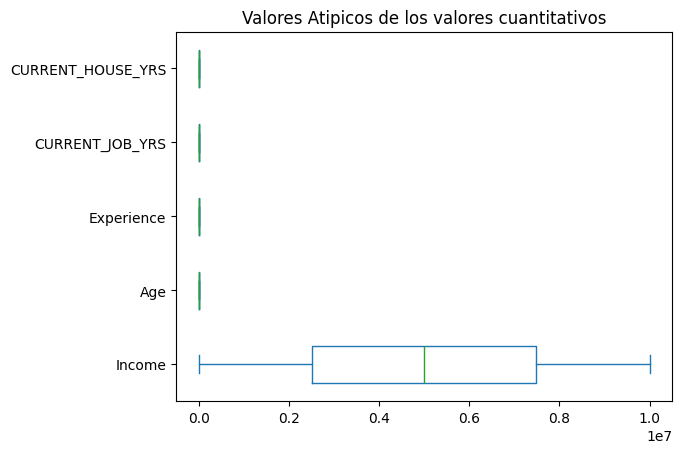

In [28]:
# Distribucion de valores atipicos
fig = plt.figure(figsize = (15, 8))
dataCuantitativas.plot(kind='box', vert=False)
plt.title('Valores Atipicos de los valores cuantitativos')
plt.show()

- 3.5 Encontrar los valores extremos por metodo de cuantiles

In [29]:
# Metodo cuantiles
# Encontramos los valores extremos
y = dataCuantitativas

percentile25 = y.quantile(0.25) #Q1
percentile75 = y.quantile(0.75) #Q3

iqr = percentile75 - percentile25

limiteSuperiorIQR = percentile75 + 1.5 * iqr
limiteInferiorIQR = percentile25 - 1.5 * iqr


print(f"Limite superior permitido :")
for col, val in limiteSuperiorIQR.items():
    print(f"{col}: {round(val, 2)}")

print(f"\n\nLimite inferior permitido :")
for col, val in limiteInferiorIQR.items():
    print(f"{col}: {round(val, 2)}")

Limite superior permitido :
Income: 14939232.5
Age: 110.0
Experience: 30.0
CURRENT_JOB_YRS: 18.0
CURRENT_HOUSE_YRS: 16.0


Limite inferior permitido :
Income: -4958715.5
Age: -10.0
Experience: -10.0
CURRENT_JOB_YRS: -6.0
CURRENT_HOUSE_YRS: 8.0


- 3.6 Identificar los Outliers

In [30]:
# Encontramos Outliers
outliers = dataCuantitativas[(y>limiteSuperiorIQR) | (y<limiteInferiorIQR)]
print(f"\nOutliers:\n")
for col, val in outliers.items():
    print(f"{col}: {round(val, 2)}")


Outliers:

Income: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Income, Length: 252000, dtype: float64
Age: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Age, Length: 252000, dtype: float64
Experience: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Experience, Length: 252000, dtype: float64
CURRENT_JOB_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: CURRENT_JOB_YRS, Length: 252000, dtype: float64
CURRENT_HOUSE_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: C

- 3.7 Pasar los outliers a nulos

In [31]:
# Convertir outliers en nulos
dataCuantitativas = dataCuantitativas[(y<=limiteSuperiorIQR) & (y>=limiteInferiorIQR)]
display(dataCuantitativas)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,
1,1303834,23,3,3,13
2,7574516,40,10,9,13
3,3991815,66,4,4,10
4,6256451,41,2,2,12
5,5768871,47,11,3,14
...,...,...,...,...,...
251996,8154883,43,13,6,11
251997,2843572,26,10,6,11
251998,4522448,46,7,7,12


- 3.8 Verificar la ausencia de valores nulos

In [32]:
# Corroboramos valores nulos
valores_nulos = dataCuantitativas.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


- 3.9 Unir las columnas cuantitativas y cualitativas

In [33]:
data = pd.concat([dataCualitativas, dataCuantitativas], axis = 1)

### 4. Obtencion de caracteristicas

- Generamos las graficas de cada una de las columnas

['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
Ciudades distintas: 317


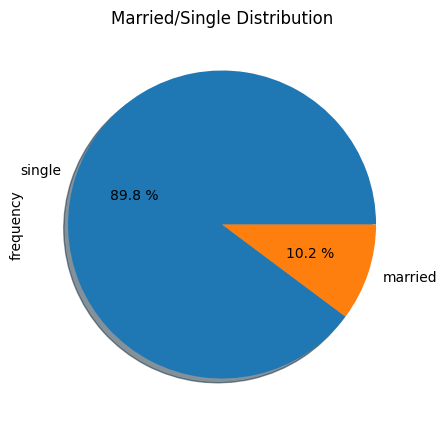

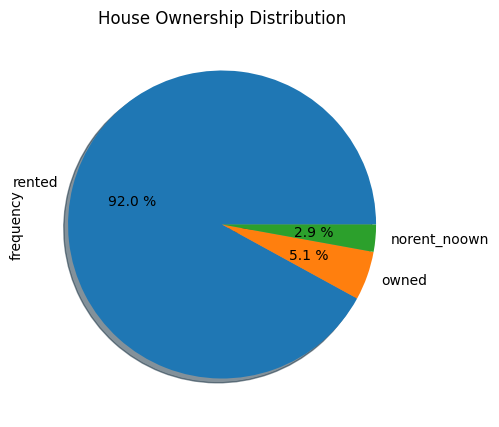

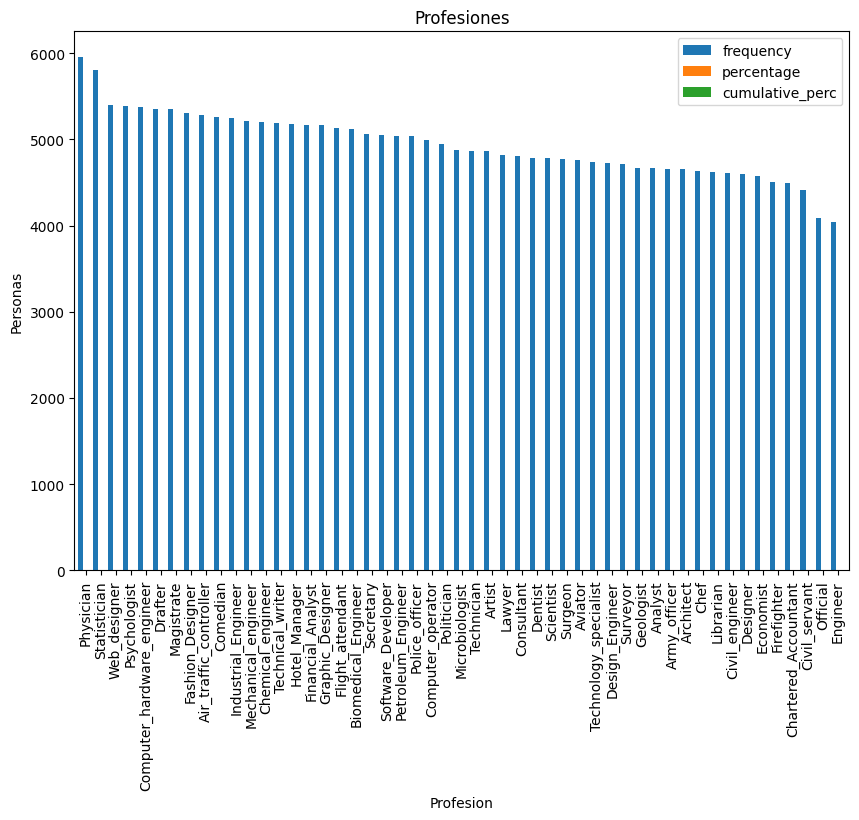

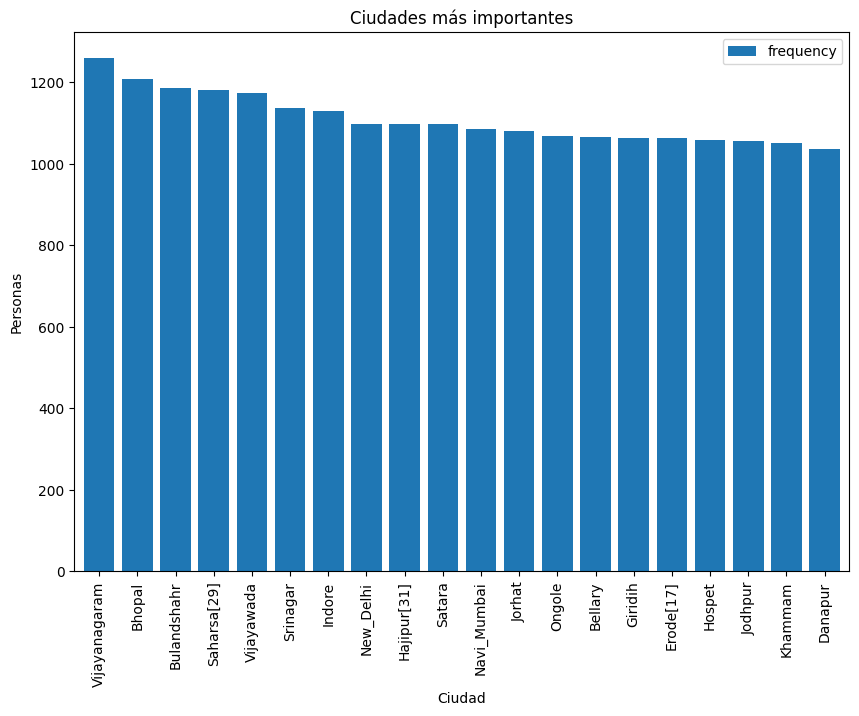

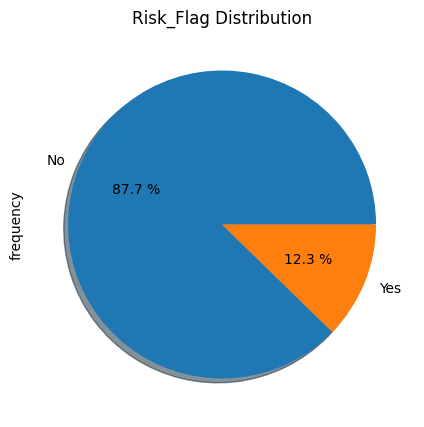

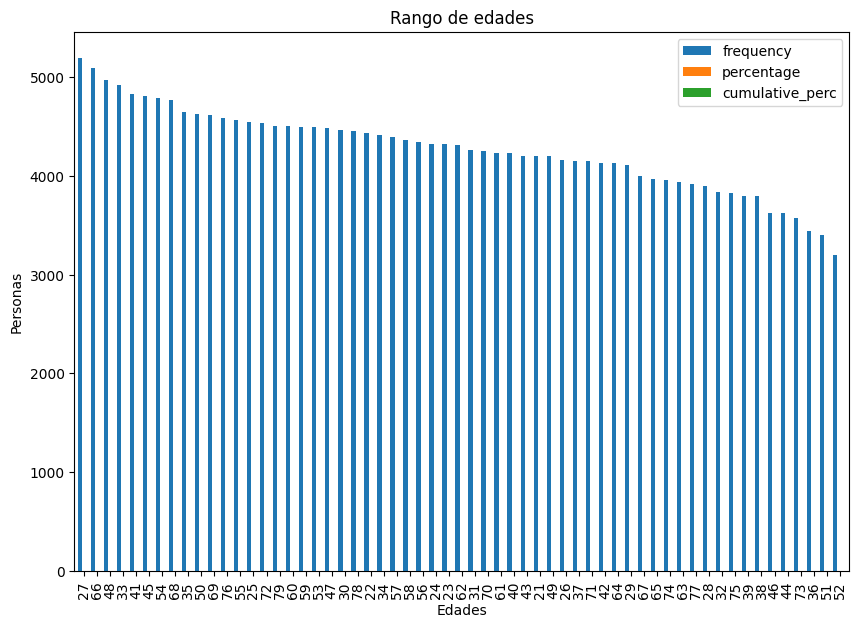

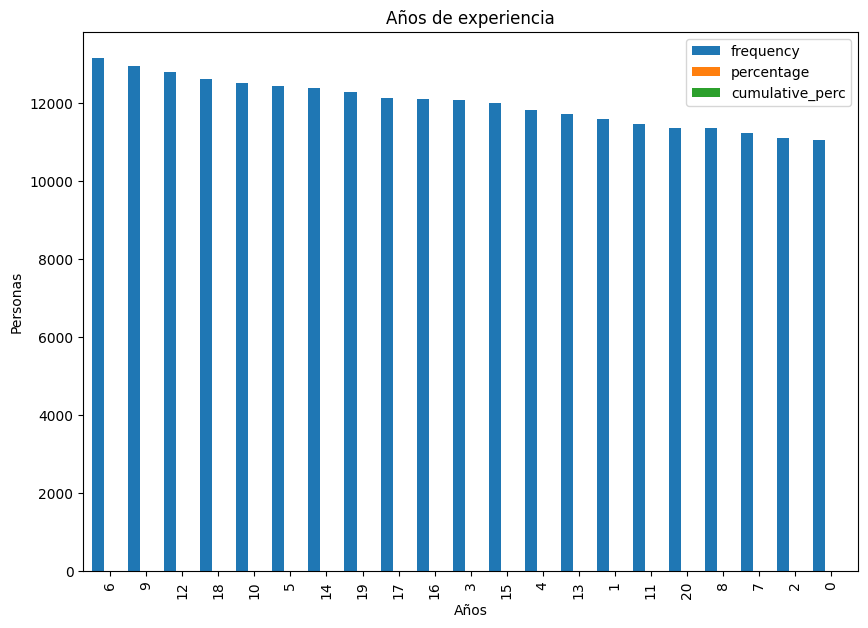

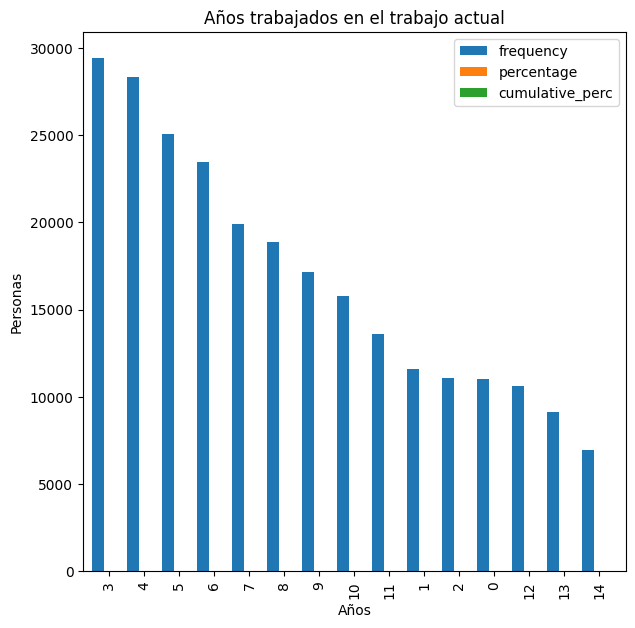

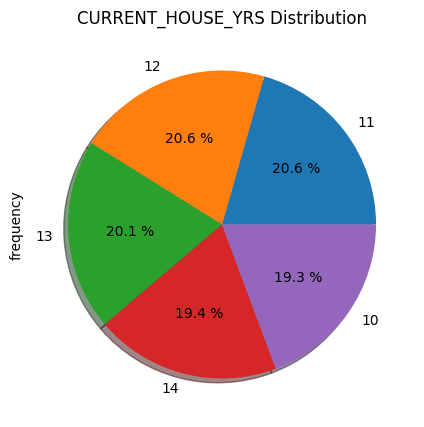

In [51]:
#Arreglo de nombre de las columnas
columnNames = []
for name in data.columns:
    columnNames.append(name)
    
print(columnNames)
    
#Mostrar todas las graficas

for name in columnNames:
    
    if name == "Married/Single":
        
        table = freq_tbl(data['Married/Single'])
        Filtro = table[table['frequency'] > 1]
        Filtro_setter = Filtro.set_index("Married/Single")
        
        fig, axes = plt.subplots(1, 1, figsize=(10, 12))
        Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")
        axes.set_title('Married/Single Distribution')
        
    if name == "House_Ownership":
        
        table = freq_tbl(data['House_Ownership'])
        Filtro1 = table[table['frequency'] > 20]
        Filtro_setter = Filtro1.set_index("House_Ownership")
        
        fig2, axes = plt.subplots(1, 1, figsize=(10, 12))
        Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")
        axes.set_title('House Ownership Distribution')
        
    if name == "Age":
        table = freq_tbl(data['Age'].astype("string"))
        Filtro = table[table['frequency']>9]
        Filtro_setter = Filtro.set_index("Age")
        Filtro_setter
        Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
        plt.title('Rango de edades')
        plt.xlabel('Edades')
        plt.ylabel('Personas')
        
    if name == "Experience":
        table = freq_tbl(data['Experience'].astype("string"))
        Filtro = table[table['frequency']>9]
        Filtro_setter = Filtro.set_index("Experience")
        Filtro_setter
        Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
        plt.title('Años de experiencia')
        plt.xlabel('Años')
        plt.ylabel('Personas')
        
    if name == "Profession":
        table = freq_tbl(data['Profession'])
        Filtro = table[table['frequency']>9]
        Filtro_setter = Filtro.set_index("Profession")
        Filtro_setter
        Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
        plt.title('Profesiones')
        plt.xlabel('Profesion')
        plt.ylabel('Personas')
        
    if name == "CITY":
        table = freq_tbl(data['CITY'])
        Filtro = table.sort_values(by='frequency', ascending=False).head(20)

        Filtro.plot(kind="bar", x="CITY", y="frequency", width=0.8, figsize=(10, 7))
        plt.title('Ciudades más importantes')
        plt.xlabel('Ciudad')
        plt.ylabel('Personas')

        print(f'Ciudades distintas: {table["CITY"].shape[0]}')
        
    if name == "CURRENT_JOB_YRS":
        table = freq_tbl(data['CURRENT_JOB_YRS'].astype("string"))
        Filtro = table[table['frequency']>9]
        Filtro_setter = Filtro.set_index("CURRENT_JOB_YRS")
        Filtro_setter.plot(kind = "bar" , width=1, figsize=(7,7))
        plt.title('Años trabajados en el trabajo actual')
        plt.xlabel('Años')
        plt.ylabel('Personas')
        
    if name == "CURRENT_HOUSE_YRS":
        table = freq_tbl(data['CURRENT_HOUSE_YRS'].astype("string"))
        Filtro = table[table['frequency'] > 20]
        Filtro_setter = Filtro.set_index("CURRENT_HOUSE_YRS")

        fig2, axes = plt.subplots(1, 1, figsize=(10, 12))
        Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")
        axes.set_title('CURRENT_HOUSE_YRS Distribution')
        
    if name == "Risk_Flag":
        table = freq_tbl(data['Risk_Flag'].astype("string"))
        Filtro = table[table['frequency'] > 2]
        Filtro_setter = Filtro.set_index("Risk_Flag")

        fig2, axes = plt.subplots(1, 1, figsize=(10, 12))
        Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")
        axes.set_title('Risk_Flag Distribution')

### 5. Analisis de correlacion por regresion logistica

- En este caso contamos con la necesidad de aplicar 10 casos diferentes de correlacion logistica, para esto generaremos los 10 casos especificos pensados como viables por el equipo y de este modo tratar de encontrar un buen modelo.

- Para este caso y evitar generar 10 bloques de codigo repetido, optaremos por generar funciones y modularizar cada uno de los pasos.

- 5.1 Generar una lista de listas con 10 posibles combinaciones para nuestros modelos de regresion Logistica

In [35]:
from itertools import combinations

def generate_combinations(input_array, num_combinations=10):
    result = []
    
    # Generate combinations of length 2
    for comb in combinations(input_array, 3):
        result.append(list(comb))
        if len(result) >= num_combinations:
            return result
    
    # Generate combinations of length 3
    for comb in combinations(input_array, 4):
        result.append(list(comb))
        if len(result) >= num_combinations:
            return result

    return result

input_array = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
independientes = generate_combinations(input_array, num_combinations=10)
print(independientes)

[['Income', 'Age', 'Experience'], ['Income', 'Age', 'CURRENT_JOB_YRS'], ['Income', 'Age', 'CURRENT_HOUSE_YRS'], ['Income', 'Experience', 'CURRENT_JOB_YRS'], ['Income', 'Experience', 'CURRENT_HOUSE_YRS'], ['Income', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], ['Age', 'Experience', 'CURRENT_JOB_YRS'], ['Age', 'Experience', 'CURRENT_HOUSE_YRS'], ['Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], ['Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']]


- 5.2 Generar los modelos de regresion logistica por cada combinacion

In [38]:
#Tomar las variables para nuestro modelo
for i,combinacion in enumerate(independientes):
    X = data[combinacion]
    y = data["Risk_Flag"]
    
    #Dividir el conjunto de datos en la parte de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = None)
    
    #Escalar los datos
    escalar = StandardScaler()
    
    #Realizar escalamiento de las variables "X" tanto de entrenamiento como de prueba
    X_train = escalar.fit_transform(X_train)
    X_test = escalar.transform(X_test)
    
    #Definimos el algoritmo a utilizar
    from sklearn.linear_model import LogisticRegression
    algoritmo = LogisticRegression()
    
    #Entrenamos el modelo
    algoritmo.fit(X_train, y_train)
    
    #Realizar prediccion
    y_pred = algoritmo.predict(X_test)
    y_pred
    
    #Generar mi matriz de confusion
    from sklearn.metrics import confusion_matrix
    matriz = confusion_matrix(y_test, y_pred)
    print(f"{cyan}Matriz de confusion y metricas de combinacion {i}:{reset}\n")
    display(matriz)
    
    #Calcular las metricas de cada modelo
    reporte=classification_report(y_test,y_pred,labels=['Yes','No'])
    print(reporte)
    
    
    

Matriz de confusion y metricas de combinacion 0:



array([[66357,     0],
       [ 9243,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9243
          No       0.88      1.00      0.93     66357

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 1:



array([[66308,     0],
       [ 9292,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9292
          No       0.88      1.00      0.93     66308

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 2:



array([[66256,     0],
       [ 9344,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9344
          No       0.88      1.00      0.93     66256

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 3:



array([[66350,     0],
       [ 9250,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9250
          No       0.88      1.00      0.93     66350

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 4:



array([[66183,     0],
       [ 9417,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9417
          No       0.88      1.00      0.93     66183

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 5:



array([[66349,     0],
       [ 9251,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9251
          No       0.88      1.00      0.93     66349

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 6:



array([[66283,     0],
       [ 9317,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9317
          No       0.88      1.00      0.93     66283

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 7:



array([[66334,     0],
       [ 9266,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9266
          No       0.88      1.00      0.93     66334

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 8:



array([[66251,     0],
       [ 9349,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9349
          No       0.88      1.00      0.93     66251

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600

Matriz de confusion y metricas de combinacion 9:



array([[66243,     0],
       [ 9357,     0]])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      9357
          No       0.88      1.00      0.93     66243

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
